# Optimzing Model Predictions

## Goal

Optimize the model prediction though different strategies if applicable:
- Handling outliers
- K-fold cross validation
- Regularization
- Non-linear models

We will start with a base model and iterate to find one that performs better.

The goal is to predict the extent of fire damage to a forest

## Data

We will use the [Forest Fires]([[https](https://archive.ics.uci.edu/ml/datasets/Forest+Fires)://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees](https://archive.ics.uci.edu/ml/datasets/Forest+Fires)) set from the UCI Machine Learning Repository. 

-  **X** : x-axis spatial coordinate within the Montesinho park map: 1 to 9
-  **Y** : y-axis spatial coordinate within the Montesinho park map: 2 to 9
-  **month** : month of the year: 'jan' to 'dec' 
-  **day** : day of the week: 'mon' to 'sun'
-  **FFMC** : FFMC index from the FWI system: 18.7 to 96.20
-  **DMC** : DMC index from the FWI system: 1.1 to 291.3 
-  **DC** : DC index from the FWI system: 7.9 to 860.6 
-  **ISI** : ISI index from the FWI system: 0.0 to 56.10
-  **temp** : temperature in Celsius degrees: 2.2 to 33.30
-   **RH** : relative humidity in %: 15.0 to 100
-   **wind** : wind speed in km/h: 0.40 to 9.40 
-   **rain** : outside rain in mm/m2 : 0.0 to 6.4 
-   **area** : the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).

## Libraries

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.metrics import  mean_squared_error

## Model Development

### Load data

In [162]:
ff = pd.read_csv('data/forestfires.csv')

### EDA

In [163]:
ff.shape

(517, 13)

In [164]:
ff.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [165]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [166]:
for col in ff.columns:
    if ff[col].dtype == 'object':
        print(col,':')
        print(list(ff[col].unique()))


month :
['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan', 'dec', 'may', 'nov']
day :
['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu']


Let's check the distribution of 'area', there is a note in the dataset that says that it is really skewed.

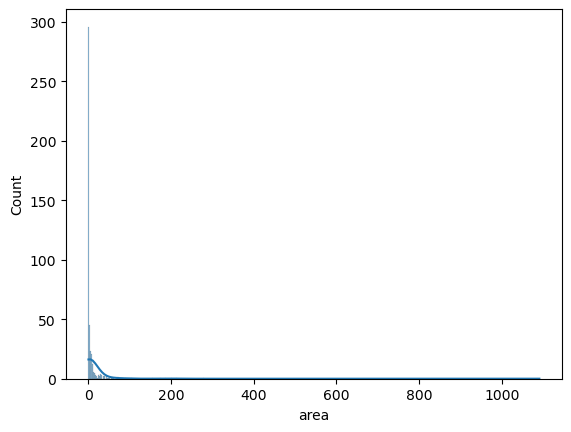

In [167]:
sns.histplot(data=ff, x='area', kde=True)
plt.show()

And did it is really skewed, and it has a big spread. We may need to keep an eye on outliers.

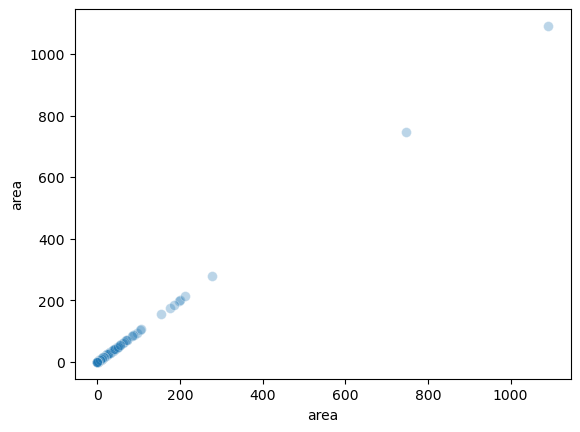

In [168]:
sns.scatterplot(data=ff, x='area', y='area', alpha=.3, s=50)
plt.show()

As the suggestion in the data says, lets apply a log to better see the spread of the data in the area column

temp


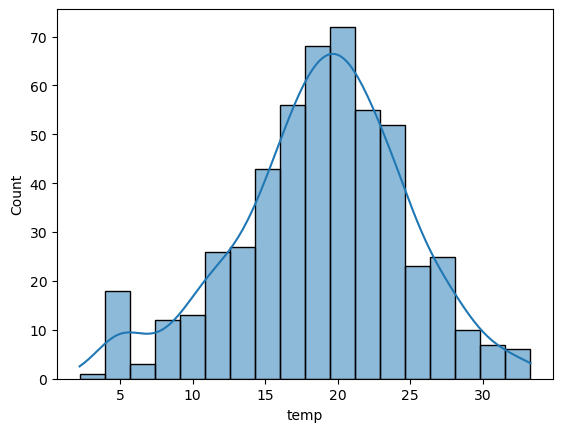

wind


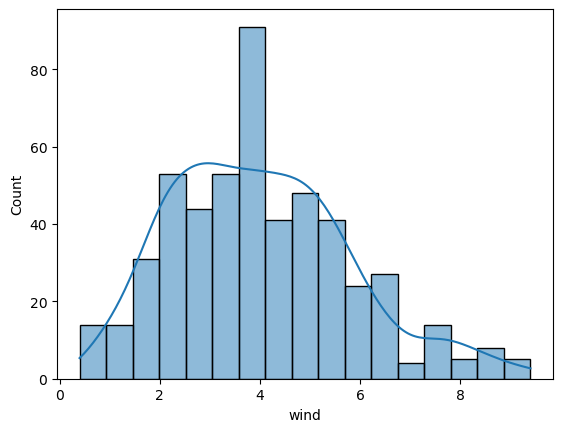

In [169]:
cols = ['temp', 'wind']

for col in cols:
    print(col)
    sns.histplot(data=ff, x=col, kde=True)
    plt.show()

In [170]:
ff.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Scaling looks like a good idea

### Outlier detection

Let's check the outliers in the numerical data, we are not going to remove them based on the target feature, because they are events that can happen in real life<br>
Scikit-Learn has different models than can help to detect outliers. But we are going to implement it though IQR (Interqurtile Range)

In [171]:
numerical_cols = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']
is_outlier_columns = []

# create a function to detect outliers... later we will see if we will delete them or not

for col in numerical_cols:
    
    q1 = ff[col].quantile(0.25)
    q3 = ff[col].quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    is_outlier_column_name = f"is_outlier__{col}"
    
    is_outlier_columns.append(is_outlier_column_name)

    # create a variable based on the column we are iterating, true if outlier
    ff[is_outlier_column_name] = (ff[col] < lower_bound) | (ff[col] > upper_bound)



In [172]:
ff[is_outlier_columns]

,is_outlier__X,is_outlier__Y,is_outlier__FFMC,is_outlier__DMC,is_outlier__DC,is_outlier__ISI,is_outlier__temp,is_outlier__RH,is_outlier__wind,is_outlier__rain,is_outlier__area
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,True,False
4,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
512,False,False,True,False,False,False,False,False,False,False,False
513,False,False,True,False,False,False,False,False,False,False,True
514,False,False,True,False,False,False,False,False,False,False,False
515,False,False,False,False,False,False,False,False,False,False,False


In [173]:
ff[is_outlier_columns].sum()

is_outlier__X        0
is_outlier__Y       51
is_outlier__FFMC    53
is_outlier__DMC     17
is_outlier__DC       8
is_outlier__ISI     23
is_outlier__temp     2
is_outlier__RH      12
is_outlier__wind    13
is_outlier__rain     8
is_outlier__area    63
dtype: int64

We won't consider the outliers from the coordinate Y, I think they can happen anywhere and in some places more often

In [174]:
numerical_cols_outliers = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
ff['is_potential_outlier'] = ff[is_outlier_columns].any(axis=1)

In [175]:
ff['is_outlier'] = ~(ff['is_outlier__area'] | ~ff['is_potential_outlier'])


In [176]:
ff[['is_potential_outlier', 'is_outlier__area', 'is_outlier']]

,is_potential_outlier,is_outlier__area,is_outlier
0,False,False,False
1,False,False,False
2,False,False,False
3,True,False,True
4,True,False,True
...,...,...,...
512,True,False,True
513,True,True,False
514,True,False,True
515,False,False,False


In [177]:
# this is the vector that tells us if the data point is outlier or not
ff['is_outlier'].sum()

138

In [178]:
# Let's clean the data frame
ff = ff.loc[:, ~ff.columns.str.contains('^is_outlier__.')]
ff = ff.drop('is_potential_outlier', axis=1)
ff.head(5).T


,0,1,2,3,4
X,7,7,7,8,8
Y,5,4,4,6,6
month,mar,oct,oct,mar,mar
day,fri,tue,sat,fri,sun
FFMC,86.2,90.6,90.6,91.7,89.3
DMC,26.2,35.4,43.7,33.3,51.3
DC,94.3,669.1,686.9,77.5,102.2
ISI,5.1,6.7,6.7,9.0,9.6
temp,8.2,18.0,14.6,8.3,11.4
RH,51,33,33,97,99


So many outliers, we will start with out them then add them to our model testing to se the effects they bring.

#### Observations

month :
['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan', 'dec', 'may', 'nov']
day :
['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu']

- There's no missing data
- The target feature 'area', is skewed and the most probable is that it has outliers
  - log1p() is a good way to deal with data skewed towards 0
- We will need to encode the categorical features
- Scaling the data will be a good idea because we have data with different orders of magnitude
- Based on the outlier analysis there are around 138 data points that are outliers

### Feature Engineering I

### Reference model

In [179]:
ref_model = LinearRegression()

Let's apply a log to the target feature to deal with the skewness

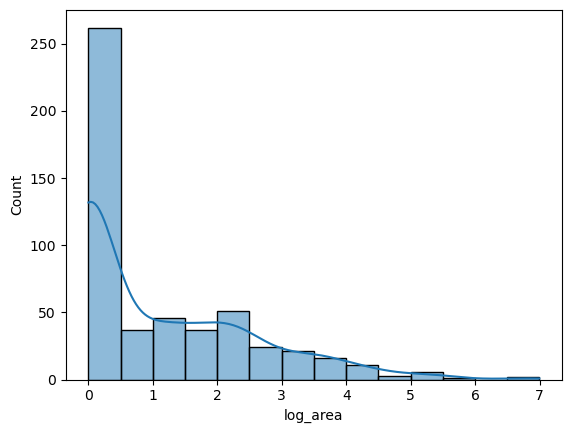

In [180]:
ff['log_area'] = np.log1p(ff['area'])

#np.log1p() which is more robust to zeros. it adds a 1 to the value before applying the log
sns.histplot(data=ff, x='log_area', kde=True)
plt.show()

Let's deal with the categorical features:
<br>
month : ['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan', 'dec', 'may', 'nov']
<br>
day : ['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu']
<br>

They are categorical ordinal features... we can use 3 encodings (ordinal, one-hot or cyclical):<br>
Cyclical encoding captures the cyclical nature of the months/days<br>
Let's use them on our two features

In [181]:
month_map = {
    'jan': 1, 
    'feb': 2, 
    'mar': 3, 
    'apr': 4, 
    'may': 5, 
    'jun': 6, 
    'jul': 7, 
    'aug': 8, 
    'sep': 9, 
    'oct': 10, 
    'nov': 11, 
    'dec': 12
    }

day_map = {
    'mon': 1,
    'tue': 2,
    'wed': 3,
    'thu': 4,
    'fri': 5,
    'sat': 6,
    'sun': 7
}

ff['day'] = ff['day'].map(day_map)
ff['month'] = ff['month'].map(month_map)



In [182]:
ff['sin_day'] = np.sin((ff['day'] - 1) * (2 * np.pi / 12))
ff['cos_day'] = np.cos((ff['day'] - 1) * (2 * np.pi / 12))


ff['sin_month'] = np.sin((ff['month'] - 1) * (2 * np.pi / 12))
ff['cos_month'] = np.cos((ff['month'] - 1) * (2 * np.pi / 12))

# the minus 1 is to adjust the range to fit the sine and cosine functions

### EDA II

Let's now visualize the features vs the target variable

In [183]:
ff.head().T

,0,1,2,3,4
X,7,7,7,8,8
Y,5,4,4,6,6
month,3,10,10,3,3
day,5,2,6,5,7
FFMC,86.2,90.6,90.6,91.7,89.3
DMC,26.2,35.4,43.7,33.3,51.3
DC,94.3,669.1,686.9,77.5,102.2
ISI,5.1,6.7,6.7,9.0,9.6
temp,8.2,18.0,14.6,8.3,11.4
RH,51,33,33,97,99


In [184]:
vis_columns = list(ff.iloc[:, :12].columns)

X :


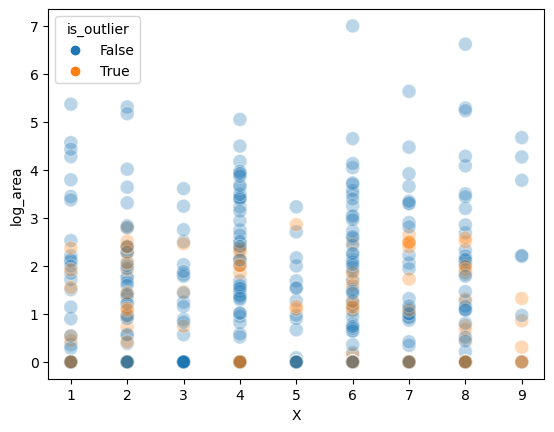

Y :


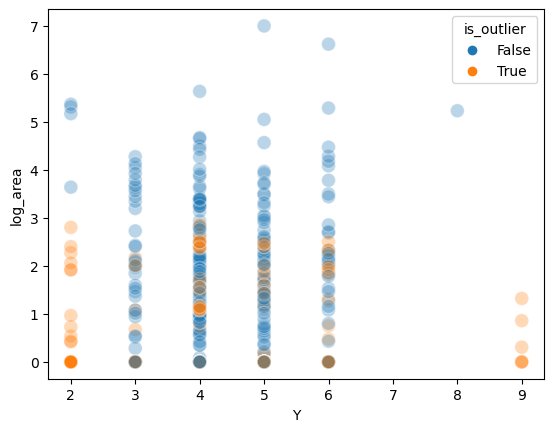

month :


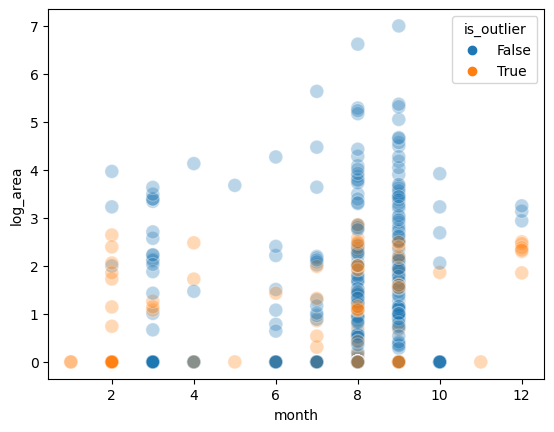

day :


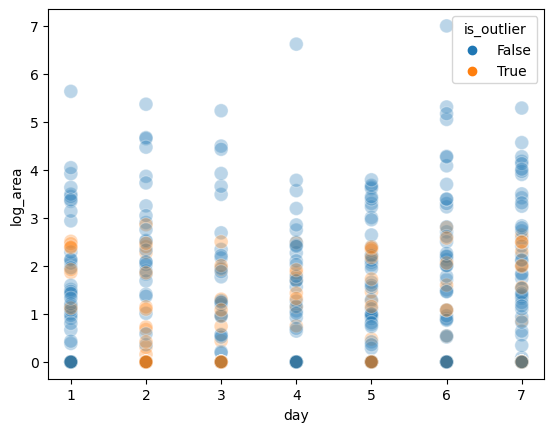

FFMC :


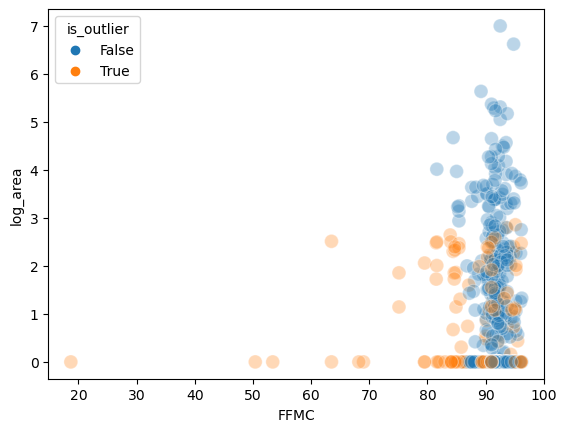

DMC :


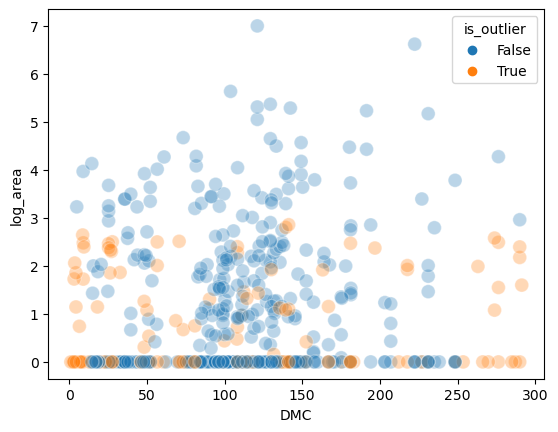

DC :


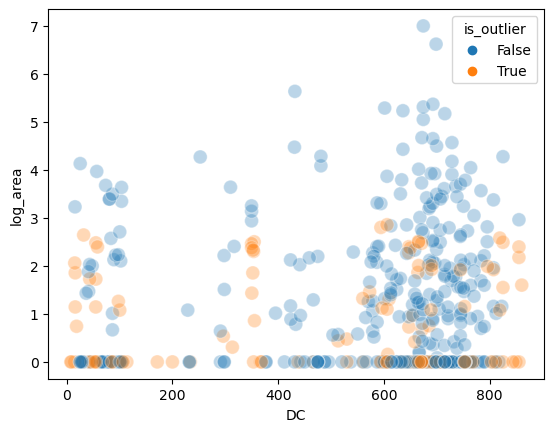

ISI :


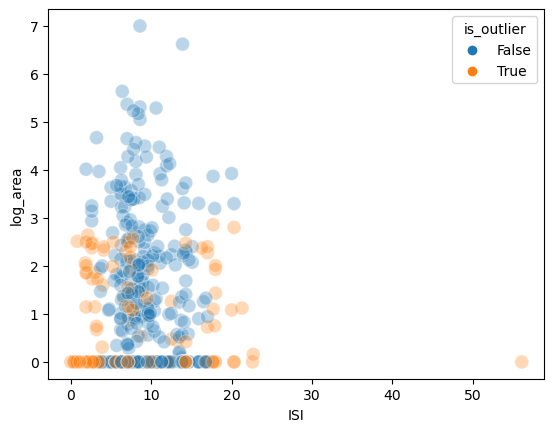

temp :


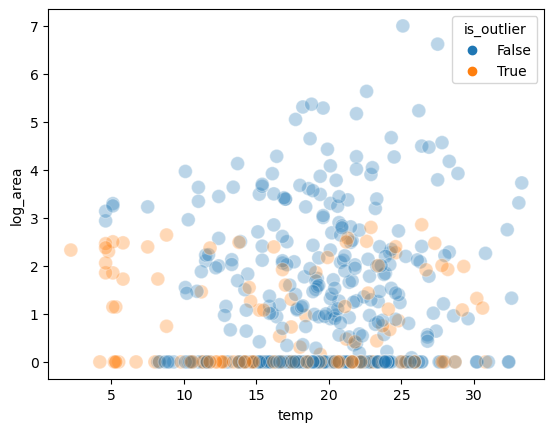

RH :


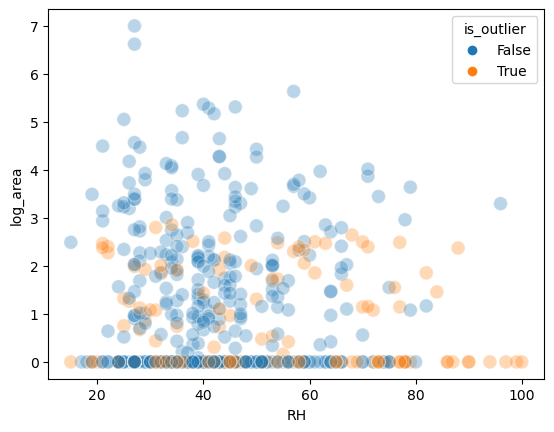

wind :


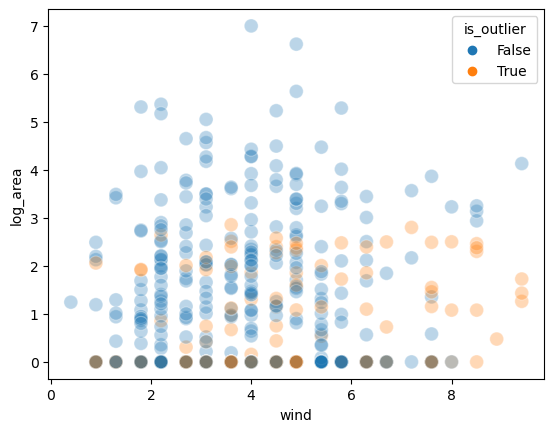

rain :


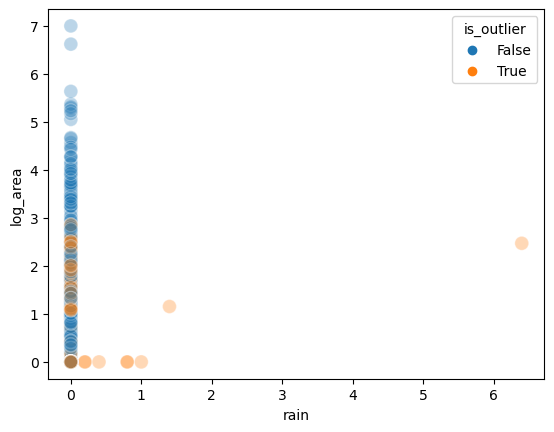

In [185]:
for col in vis_columns:
    
    print(col, ':')
    sns.scatterplot(data=ff, y='log_area', x=col, hue='is_outlier', s=100, alpha=.3)
    plt.show()

#### Observations

- area
  - In most of the cases the outiers are distributed withing the each variable, if we remove them we may see not negative errors
  - The relationships of the feature vs the target variable all looks like are linear if we ignore the abnormally big fires
- log_area
  - If we use the transformed 'log_area' the data looks totally different
    - we got rid out the 'outliers' big fires
    - For 'rain', 'ISI' and 'FFMC' it looks like the data clusters at certain values

### Training and Testing datasets

In [186]:
# we have the encoded ones, with sin and cos
ff = ff.drop(['day', 'month', 'is_outlier'], axis=1)
ff.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,is_outlier,log_area,sin_day,cos_day,sin_month,cos_month
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,False,0.0,8.660254e-01,-0.500000,0.866025,5.000000e-01
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,False,0.0,5.000000e-01,0.866025,-1.000000,-1.836970e-16
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,False,0.0,5.000000e-01,-0.866025,-1.000000,-1.836970e-16
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,True,0.0,8.660254e-01,-0.500000,0.866025,5.000000e-01
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,True,0.0,1.224647e-16,-1.000000,0.866025,5.000000e-01


In [192]:
y = ff[['area', 'log_area']]
X = ff.drop(['area', 'log_area', 'is_outlier'], axis=1)

In [193]:
X

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,sin_day,cos_day,sin_month,cos_month
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,8.660254e-01,-0.500000,0.866025,5.000000e-01
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,5.000000e-01,0.866025,-1.000000,-1.836970e-16
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,5.000000e-01,-0.866025,-1.000000,-1.836970e-16
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,8.660254e-01,-0.500000,0.866025,5.000000e-01
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.224647e-16,-1.000000,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1.224647e-16,-1.000000,-0.500000,-8.660254e-01
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,1.224647e-16,-1.000000,-0.500000,-8.660254e-01
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,1.224647e-16,-1.000000,-0.500000,-8.660254e-01
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,5.000000e-01,-0.866025,-0.500000,-8.660254e-01


In [199]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Reference model

In [224]:
from sklearn.metrics import mean_squared_error


In [227]:
ref_model_area = LinearRegression()
ref_model_log_area = LinearRegression()


models = [ref_model_area, ref_model_log_area]
target_feats = ['area', 'log_area']
mses = []

for model, target_feat in zip(models, target_feats):
    
    print(model, ':', target_feat)
    

    model.fit(X_train, y_train[target_feat])
    pred = ref_model_area.predict(X_test)
    print(pred)
    
    if target_feat == 'log_area':
        mse = mean_squared_error(np.expm1(y_test[target_feat]), pred) 
    else:
        mse = mean_squared_error(y_test[target_feat], pred)
    
    mses.append(mse)
    
    print(mse)

LinearRegression() : area
[ -4.91608902  17.51863236  32.66904842   7.14188341   9.31143154
   2.10092122   1.68737479   3.40393393   2.75364939   4.4133084
   8.90015918  10.96413071  15.76333943   1.58106269  13.55534833
  -0.72751179  -1.23552176  15.24752504  23.84520896  12.1577579
   3.42538408  19.02857444  18.36525104  20.40370451   2.37449637
  27.38923418  20.62505031  32.66455787  11.19069903   1.6456734
   7.50070014  16.30826144   9.74935488  15.71421138   9.64954424
  17.23434718   8.03162431  15.9848318   16.49760401  -1.48840905
  31.67119084  11.83359917   2.83623669  21.65780131  22.57793592
  19.58389446 -11.1113785    5.99042794  10.16567752   8.99837792
   5.40122611  23.04165478  18.75856503   1.64068602  13.97011793
   7.82064274   6.6105831   12.2540766   10.29332401   4.95533251
   8.70394228   6.14103044  20.45229505  -4.17672501  16.80895327
  14.52237435   5.70916731  29.27188233  21.50344071   5.36248771
   4.74422831   7.41368784   1.30139934   4.31998832 

For the second model we got a smaller MSE but remember that it is because the data is scaled with a log1p, we added a if condition to turn back the predictions to the original scale.<br>
The models have the same predictions and mse, it doesn't matter if i use the target feature with our without log1p

Let's use cross-validation to get a stronger baseline model, we will use the non-scaled target feature

In [212]:
from sklearn.model_selection import cross_val_score

In [215]:
X_scaled = scaler.fit_transform(X)

In [222]:
cv = cross_val_score(ref_model_area, X, y['area'], cv=5, scoring='neg_mean_squared_error')
print(f" Mean -MSE: {cv.mean()}")
print(f" Min -MSE: {cv.min()}")
print(f" Max -MSE: {cv.max()}")

 Mean -MSE: -4247.464231033746
 Min -MSE: -13355.194063502864
 Max -MSE: -271.86339268069185


We have a big range in the MSE, suggesting we have data harder to predict for the model. On the simple model we got a MSE of 11568 by chance of the random split.<br>
By using multiple splits we got a more representative estimate of 4247 on 5 folds. This is our real base line

### Model fitting I

Lets perform sequential feature selection to find features that perform well in the model, we'll use forward